# LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Importa la clase ExponentialSmoothing para usar sus funciones básicas en el modelo de Holt-Winters.
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
%matplotlib inline

# EXPLORE DATA

In [ ]:
# READ CSV FILE
path = '/content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING TESIS/TIME-SERIES-Diario-13-23.csv'
# path = '/content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING TESIS/TIME-SERIES-Mensual-86-23.csv' # MONTHLY DATA
series = pd.read_csv(path,delimiter=',')
series.head()

,Año,Mes,Dia,Fecha,Tｰ Media,TｰMaxima,TｰMinima,Lluvia,%Humedad
0,2013,Ene,1,1/1/2013,12.038,18.022,7.344,0.956,73.676
1,2013,Ene,2,1/2/2013,12.224,18.000,8.078,3.600,74.553
2,2013,Ene,3,1/3/2013,11.902,17.822,7.667,9.933,76.719
3,2013,Ene,4,1/4/2013,10.906,16.778,7.122,8.800,79.117
4,2013,Ene,5,1/5/2013,11.146,16.267,7.211,4.956,79.746


In [ ]:
#Check for null values
series.isnull().any()

Año         False
Mes         False
Dia         False
Fecha       False
Tｰ Media    False
TｰMaxima    False
TｰMinima    False
Lluvia      False
%Humedad    False
dtype: bool

In [ ]:
# DROP NULL VALUES
series.dropna(inplace=True)

In [ ]:
# Columna Fecha a formato Date
series['Fecha'] = pd.to_datetime(series['Fecha'])
series.set_index('Fecha', inplace=True)
# Change header names
series = series.rename(columns={"Tｰ Media": "Temp_media", "TｰMaxima": "Temp_max", "TｰMinima": "Temp_min", "Lluvia": "Precipitacion", "%Humedad": "Humedad"})
series = series.drop(["Año", "Mes", "Dia", "Temp_media", "Temp_min", "Precipitacion", "Humedad"], axis=1)
series.head(2)

,Temp_max
Fecha,
2013-01-01,18.022
2013-01-02,18.000


In [ ]:
# DATA SET INFORMATION
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3883 entries, 2013-01-01 to 2023-08-19
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Temp_max  3883 non-null   float64
dtypes: float64(1)
memory usage: 60.7 KB


In [ ]:
# Basic descriptive stats
series.describe()

,Temp_max
count,3883.000000
mean,18.019176
std,2.143404
min,6.000000
25%,16.700000
50%,18.100000
75%,19.400000
max,24.900000


# MODELS

**Simple Exponential Smoothing / Simple Moving Average**:
This is the simplest to forecast.
`y` is equal to the most recent value in the dataset, and the forecast plot is simply a horizontal line extending from the most recent value.

**Double Exponential Smoothing / Holt's Method**:
This model takes trend into account. Here the forecast plot is still a straight line extending from the most recent value, but it has slope.

**Triple Exponential Smoothing / Holt-Winters Method**:
This model has (so far) the "best" looking forecast plot, as it takes seasonality into account. When we expect regular fluctuations in the future, this model attempts to map the seasonal behavior.

In [ ]:
# CANTIDAD DE ELEMENTOS
len(series)

3883

In [ ]:
# SPLIT DATA (75%)
train_data = series.iloc[:2912]
test_data = series.iloc[2912:]

Text(0, 0.5, 'Temperatura Maxima (° C)')

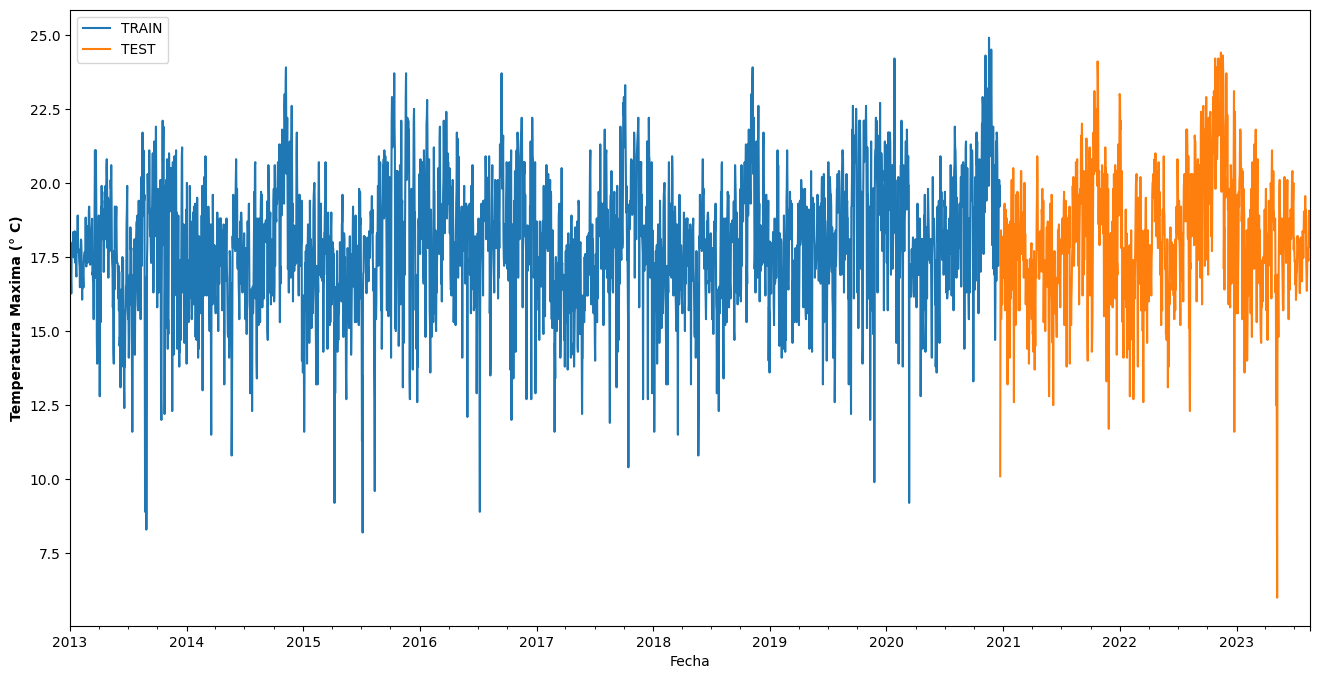

In [ ]:
# PLOT SPLIT
train_data['Temp_max'].plot(legend=True,label='TRAIN')
test_data['Temp_max'].plot(legend=True,label='TEST',figsize=(16,8));
plt.ylabel('Temperatura Maxima (° C)', fontweight='bold')

# OPTIMIZATION

In [ ]:
# Parámetros para la búsqueda de cuadrícula
param_grid = {
    'trend': ['add', 'mul'],
    'seasonal': ['add', 'mul'],
    'seasonal_periods': [30, 100, 200, 250, 270, 312, 325, 350, 365, 400]
}

In [ ]:
best_score = -float('inf')
best_params = None

In [ ]:
# Búsqueda de cuadrícula
for params in ParameterGrid(param_grid):
    model = ExponentialSmoothing(train_data['Temp_max'], **params).fit()
    forecast = model.forecast(len(test_data))
    score = r2_score(test_data, forecast)
    if score > best_score:
        best_score = score
        best_params = params

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/sta

In [ ]:
# Print the best parameters found
print("Best Parameters:")
print(best_params)

Best Parameters:
{'seasonal': 'add', 'seasonal_periods': 365, 'trend': 'add'}


## MULTIPLICATIVE

***Multiplicative Model:***

A multiplicative model suggests that the components are multiplied together as follows:

`y(t) = Level * Trend * Seasonality * Noise`

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line.
A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

In [ ]:
# USE EXPONENTIAL SMOOTHING MULTIPLICATIVE MODEL WITH PARAMETERS
train = train_data['Temp_max']
mult_model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=365).fit()
#FORECAST MODEL
mult_forecast = mult_model.forecast(971).rename('HW Forecast')
mult_forecast.head(4)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2020-12-22    17.633441
2020-12-23    17.472514
2020-12-24    19.205148
2020-12-25    18.958666
Freq: D, Name: HW Forecast, dtype: float64

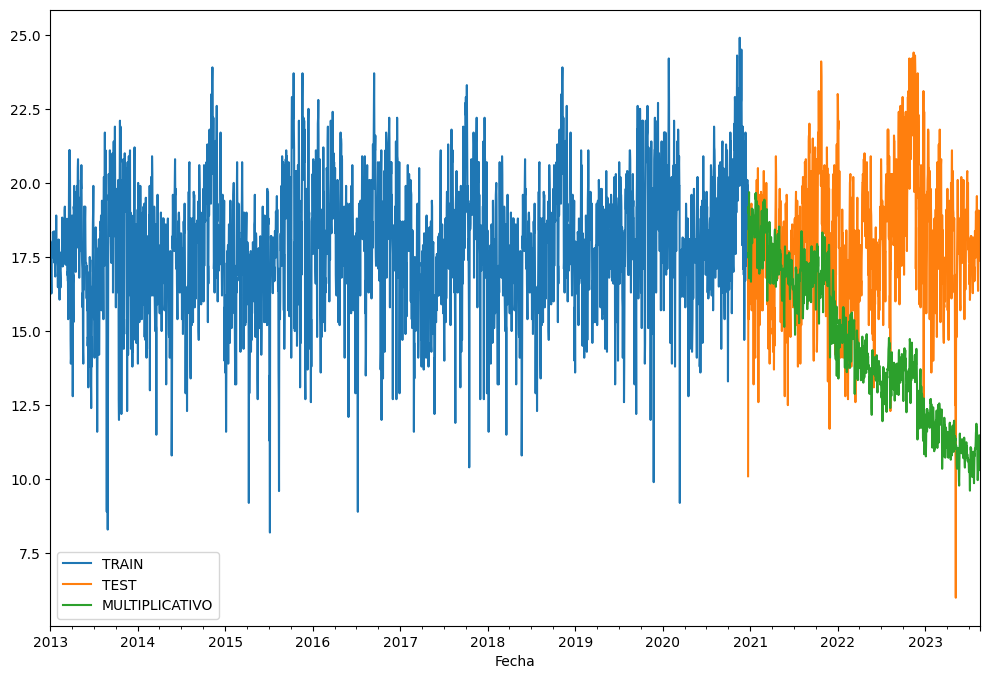

In [ ]:
# PLOT FORECASTING
train_data['Temp_max'].plot(legend=True, label='TRAIN')
test_data['Temp_max'].plot(legend=True, label='TEST', figsize=(12,8))
mult_forecast.plot(legend=True, label='MULTIPLICATIVO');

In [ ]:
# # Zoom in to get a better view of forecast
# train_data['Temp_max'].plot(legend=True, label='TRAIN')
# test_data['Temp_max'].plot(legend=True, label='TEST', figsize=(12,8))
# mult_forecast.plot(legend=True, label='PREDICTION', xlim=['2020-01-01','2023-01-01']);

In [ ]:
# print(f"Length of test_data: {len(test_data)}")
# print(f"Length of mult_forecast: {len(mult_forecast)}")

In [ ]:
# Metric evaluation of multiplicative model
print('Multiplicative Model Evaluation')
# print(f"R-cuadrado: {r2_score(test_data,mult_forecast)}")
# print(f"MSE : {mean_squared_error(test_data,mult_forecast)}")
print(f"MAE : {mean_absolute_error(test_data,mult_forecast)}")
print(f"RMSE : {mean_squared_error(test_data,mult_forecast)**.5}")
print(f"MAPE : {mean_absolute_percentage_error(test_data, mult_forecast) * 100}%")

Multiplicative Model Evaluation
MAE : 4.242850049575341
RMSE : 5.061091465754991
MAPE : 22.67719882653853%


## ADDITIVE

***Additive Model:***

An additive model suggests that the components are added together as follows:

`y(t) = Level + Trend + Seasonality + Noise`

An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line.
A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

In [ ]:
# USE EXPONENTIAL SMOOTHING ADDITIVE MODEL WITH PARAMETERS
train = train_data['Temp_max']
add_model = ExponentialSmoothing(train_data['Temp_max'],trend='add',seasonal='add',seasonal_periods=365).fit()
# FORECAST MODEL
add_forecast = add_model.forecast(971).rename('HW ADD Model')
add_forecast.head(4)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2020-12-22    17.742158
2020-12-23    17.657153
2020-12-24    19.186548
2020-12-25    19.130222
Freq: D, Name: HW ADD Model, dtype: float64

<Axes: xlabel='Fecha'>

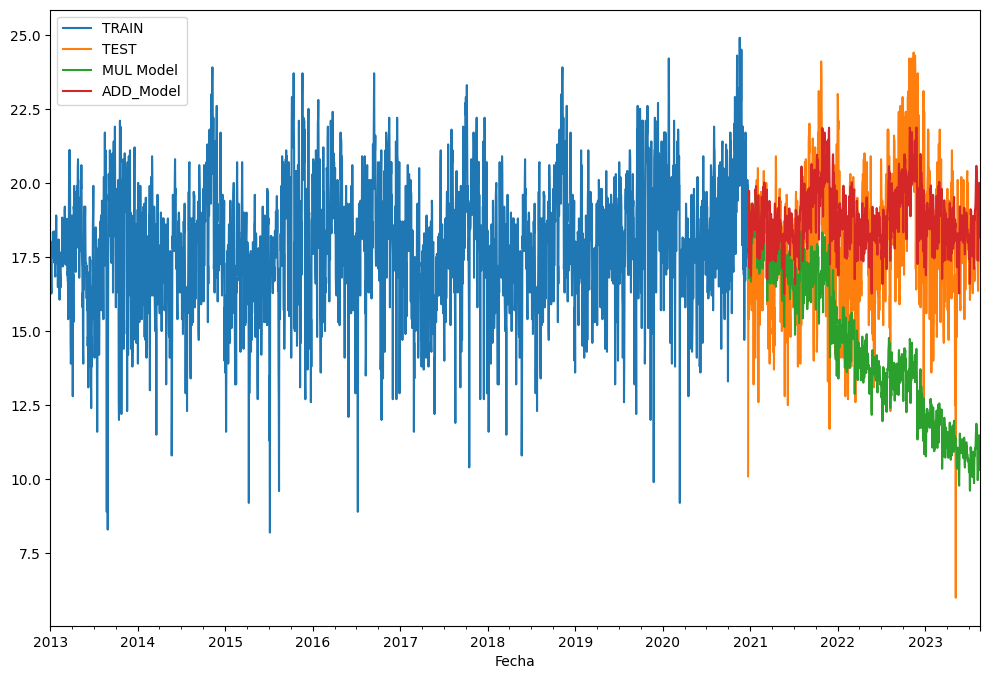

In [ ]:
# PLOT FORECASTING
train_data['Temp_max'].plot(legend=True, label='TRAIN')
test_data['Temp_max'].plot(legend=True, label='TEST', figsize=(12,8))
mult_forecast.plot(legend=True, label='MUL Model')
add_forecast.plot(legend=True, label='ADD_Model')

In [ ]:
# # Zoom in to get a better view
# train_data['Temp_max'].plot(legend=True, label='TRAIN')
# test_data['Temp_max'].plot(legend=True,label='TEST', figsize=(18,10))
# mult_forecast.plot(legend=True, label='MUL Model')
# add_forecast.plot(legend=True, label='ADD Model', xlim=['2020-01-01','2023-01-01']);

In [ ]:
# Metric evaluation of additive model
print('Additive Model Evaluation')
# print(f"R-cuadrado : {r2_score(test_data,add_forecast)}")
# print(f"MSE : {mean_squared_error(test_data,add_forecast)}")
print(f"MAE : {mean_absolute_error(test_data,add_forecast)}")
print(f"RMSE : {mean_squared_error(test_data,add_forecast)**.5}")
print(f"MAPE : {mean_absolute_percentage_error(test_data, add_forecast) * 100}%")

Additive Model Evaluation
MAE : 1.6910702470281036
RMSE : 2.2042680193811917
MAPE : 10.033389291037626%


# FORECASTING

In [ ]:
# MODEL USING EXPONENTIALM SMOOTHING
# final_model = ExponentialSmoothing(series['Humedad'],trend='add',seasonal='add',seasonal_periods=525).fit()
# Entrenamiento final con los mejores parámetros
final_model = ExponentialSmoothing(train_data['Temp_max'], **best_params).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# FORECAST FOR X DAYS
# forecast_predictions = final_model.forecast(1080)

# Predicción con el modelo final
forecast_predictions = final_model.forecast(len(test_data)).rename('HW Forecast')

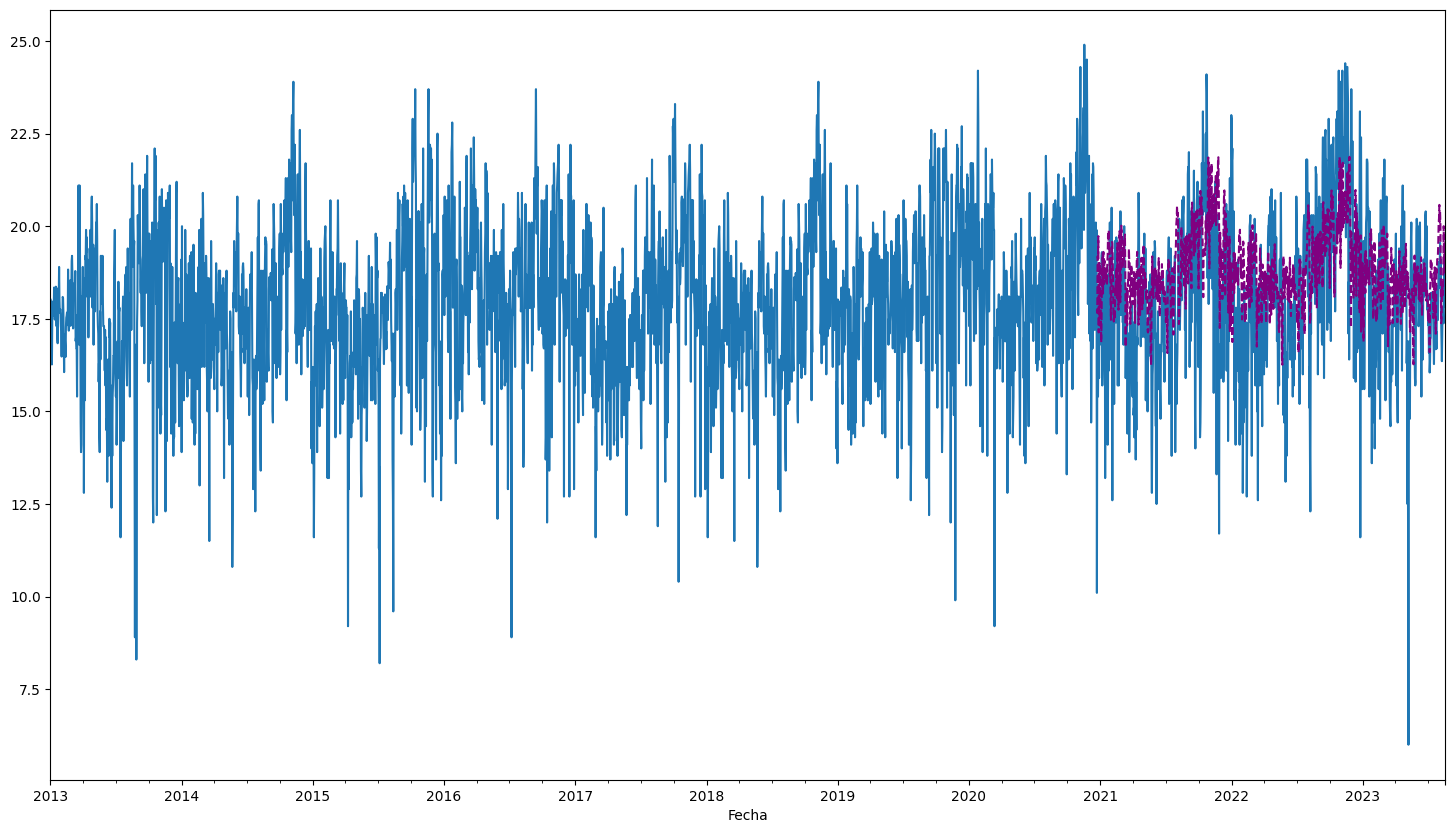

In [ ]:
# PLOT FUTURE FORECAST
series['Temp_max'].plot(figsize=(18,10))
forecast_predictions.plot(style='--', color='purple');
# fit1.forecast(12).plot(style='--', marker='o', color='green')

In [ ]:
# Evaluación del modelo final
print('Mejores parámetros encontrados:', best_params)
print('R-cuadrado del modelo final:', r2_score(test_data, forecast_predictions))


Mejores parámetros encontrados: {'seasonal': 'add', 'seasonal_periods': 365, 'trend': 'add'}
R-cuadrado del modelo final: -0.029991597331092024


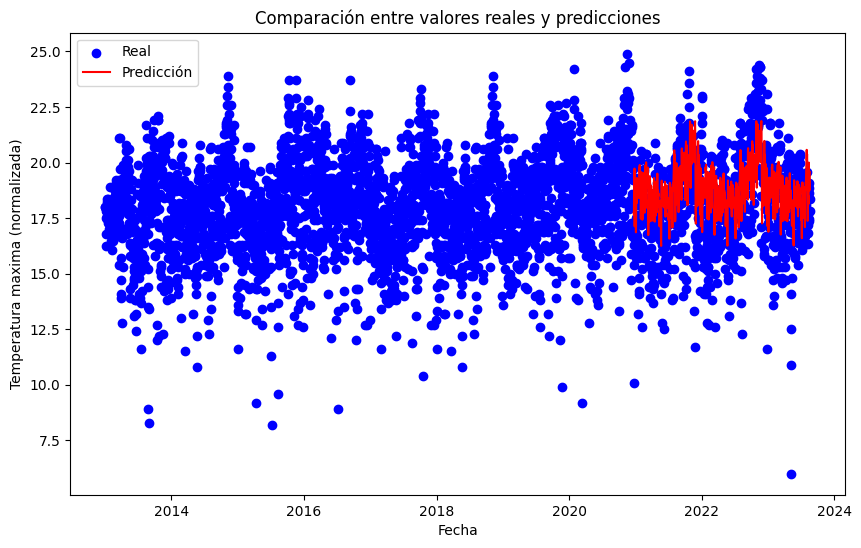

In [ ]:
# Gráfico de dispersión de puntos entre los valores reales y las predicciones
plt.figure(figsize=(10, 6))
plt.scatter(series.index, series['Temp_max'], color='blue', label='Real')
plt.plot(test_data.index, forecast_predictions, color='red', label='Predicción')
plt.xlabel('Fecha')
plt.ylabel('Temperatura maxima (normalizada)')
plt.title('Comparación entre valores reales y predicciones')
plt.legend()
plt.show()

In [ ]:
# FORECAST FOR X DAYS
forecast_predictions = final_model.forecast(1461)

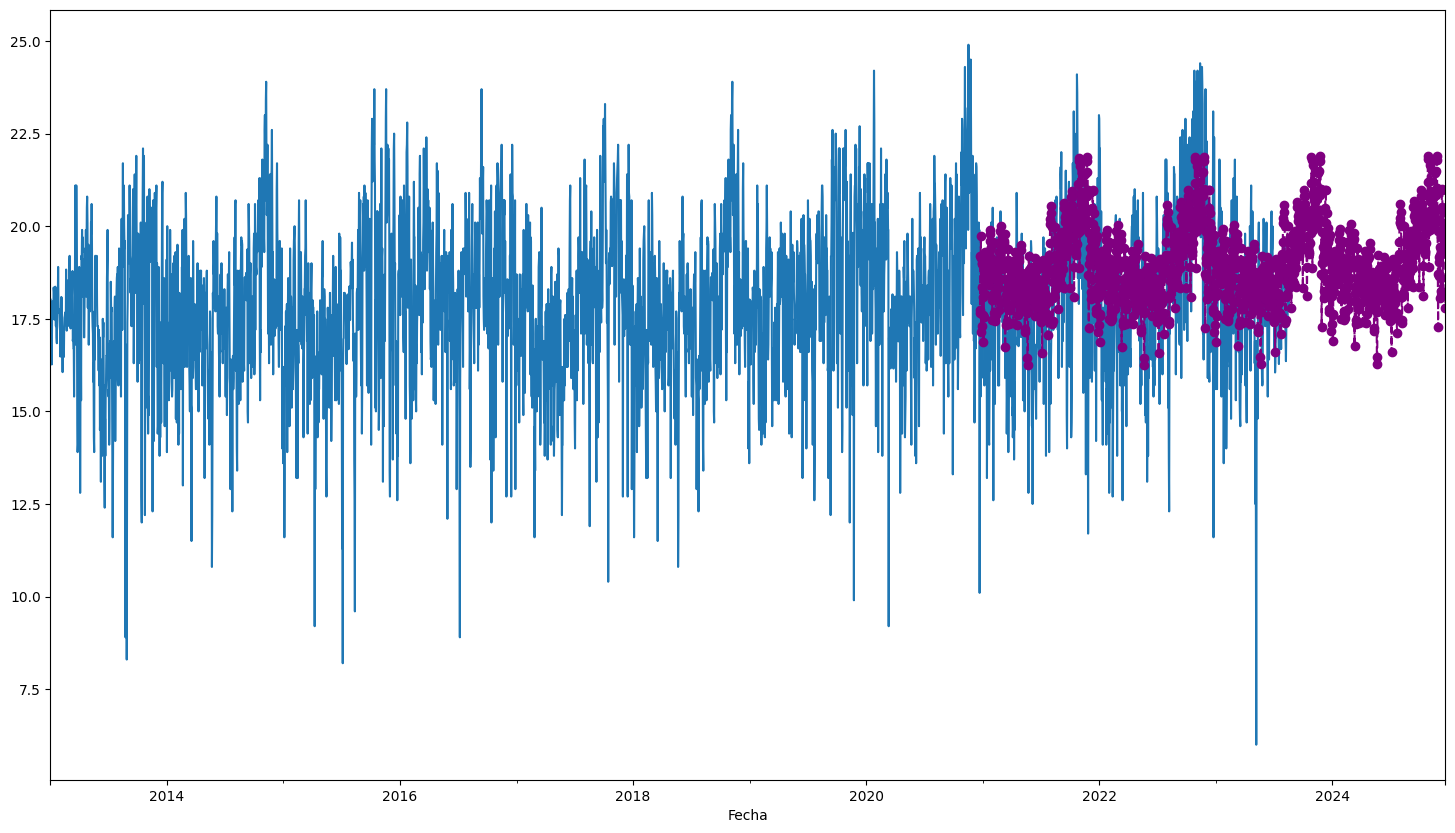

In [ ]:
# PLOT FUTURE FORECAST
series['Temp_max'].plot(figsize=(18,10))
forecast_predictions.plot(style='--', marker='o', color='purple');
# fit1.forecast(12).plot(style='--', marker='o', color='green')